# Buffer Stock Model

This notebooks shows you how to use the tools of the **consav** package to solve the canonical **buffer-stock consumption model** with either

1. **vfi**: standard value function iteration
2. **nvfi**: nested value function iteration
3. **egm**: endogenous grid point method

In all cases, each time step is solved using fully [Numba](http://numba.pydata.org/) just-in-time compilled code. Numba automatically convert Python and NumPy code into fast machine code. Specifically, this is done for all functions preceded (decorated) with ``@njit`` or ``@njit(parallel=True)`` when parallization is used.

## Model equations

The model's **bellman equation** is given by

$$ 
\begin{aligned}
v_{t}(p_{t},m_{t}) &= \max_{c_t}\frac{c^{1-\rho}}{1-\rho} + \beta v_{t+1}(p_{t+1},m_{t+1}) \\
& \text{s.t.} \\ 
a_{t} &=m_{t}-c_{t} \\
p_{t+1} &=\psi_{t+1} p_{t} \\
\tilde{\xi}_{t+1} &= \begin{cases}
\mu & \text{with prob.}\pi\\
\frac{\xi_{t+1}-\pi\mu}{1-\pi} & \text{else}
\end{cases} \\
m_{t+1} &= R a_{t} + \tilde{\xi}_{t+1}p_{t+1}\\
a_t&\geq 0\\
\end{aligned}
$$

where

$$ \begin{aligned}
\log\psi_{t+1} &\sim \mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\
\log\xi_{t+1} &\sim \mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned}
$$

In the **last period** there is no continuation value

$$ 
\begin{aligned}
v_{T+1}(m_{T+1},p_{t+1}) &= 0
\end{aligned}
$$

The **post-decision** value function is

$$
\begin{aligned}
w_t(p_t,a_t) &= \beta v_{t+1}(m_{t+1},p_{t+1})
\end{aligned} 
$$

The **Euler-equation** (required when solving with EGM) is 

$$ 
\begin{aligned}
C_{t}^{-\rho} &= q_t(p_t,a_t) \\
 &= \beta R \mathbb{E}_t[C_{t+1}(p_{t+1},m_{t+1})^{-\rho}] 
\end{aligned}
$$

where $q_t(p_t,a_t)$ is the post-decision marginal value of cash.

## Overview

The model solved in this notebook is written in **BufferStockModel.py**. 

It provides a class called **BufferStockModelClass** inheriting its basic interface from the **ModelClass**. 

A short **overview** of the interface is:

1. Each instance of the BufferStockModel class must have a **name** and a **solmethod**, and must contain **two central methods**: 
  1. **setup()**: set baseline parameters in `.par` + set list of non-float scalars in `.non_float_list` (for safe type-inference)
  2. **allocate()**: allocate memory for `.par`, `.sol` and `.sim`
2. **Type-inference:** When initializing the model with `BufferStockModelClass()` the `setup()` and `allocate()` methods are called, and the types of all variables in `.par`, `.sol` and `.sim` are inferred. Results can be seen in `.parlist`, `.sollist` and `.simlist` or by `print(model)`.
3. The **solve()** method solves the model
4. The **simulate()** method simulates the model
5. The **save()** method saves the model naming it **data/name_solmethod**
6. The **copy()** makes a deep copy of the model

In addition to **BufferStockModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value function in last period
2. **utility.py**: utility function and marginal utility function
3. **post_decision.py**: calcualte $w$ and $q$
4. **vfi.py**: solve with value function iteration
5. **nvfi.py**: solve with nested value function iteration
6. **egm.py**: solve with the endogenous grid method
7. **simulate.py**: simulate for all solution methods
8. **figs.py**: plot figures

The functions in these modules are loaded in **BufferStockModel.py**.

The folder **cppfuncs** contains C++ functions not used in this notebook.

## Numba

Before (important!) you load **Numba** you can disable it or choose the number of threads as follows:

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

This writes a file called *.numba_config.yaml* which Numba loads when being imported.

Disabling Numba makes the code run much slower, but can be beneficial when debugging.

# Setup

In [2]:
%matplotlib inline

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

# First Example

The code is easiest to understand for **nvfi** and **do_simple_w = True**. The cell below solves the model using these settings. Go through the code the cell is calling to understand the interface.

In [3]:
# a. setup (calling the __init__ method) 
model = BufferStockModelClass(name='baseline',solmethod='nvfi',do_simple_w=True)

# name: required
# solmethod: optional (default: None)
# compiler: optional (default: 'vs')
# **kwargs: update parameters in .par AFTER calling .setup

# b. print
print(model)

# c. solve
model.solve()

# d. simulate
print('')
model.simulate()

# e. save
model.save()       

Modelclass: BufferStockModelClass

Parameters:
 T = 5 [int64]
 beta = 0.96 [float64]
 rho = 2.0 [float64]
 R = 1.03 [float64]
 sigma_psi = 0.1 [float64]
 Npsi = 6 [int64]
 sigma_xi = 0.1 [float64]
 Nxi = 6 [int64]
 pi = 0.1 [float64]
 mu = 0.5 [float64]
 Nm = 600 [int64]
 Np = 400 [int64]
 Na = 800 [int64]
 tol = 1e-08 [float64]
 do_print = True
 do_simple_w = True
 cppthreads = 1 [int64]
 simT = 5 [int64]
 simN = 1000 [int64]
 sim_seed = 1998 [int64]
 grid_m = array(float64, 1d, C) with shape = (600,)
 grid_p = array(float64, 1d, C) with shape = (400,)
 grid_a = array(float64, 1d, C) with shape = (800,)
 psi = array(float64, 1d, C) with shape = (42,)
 psi_w = array(float64, 1d, C) with shape = (42,)
 xi = array(float64, 1d, C) with shape = (42,)
 xi_w = array(float64, 1d, C) with shape = (42,)
 Nshocks = 42 [int64]
memory, gb: 0.0

Solution:
 c = array(float64, 3d, C) with shape = (5, 400, 600)
 v = array(float64, 3d, C) with shape = (5, 400, 600)
 w = array(float64, 2d, C) with shape

**Check typer inference:**

In [4]:
model.parlist

[('T', int64),
 ('beta', float64),
 ('rho', float64),
 ('R', float64),
 ('sigma_psi', float64),
 ('Npsi', int64),
 ('sigma_xi', float64),
 ('Nxi', int64),
 ('pi', float64),
 ('mu', float64),
 ('Nm', int64),
 ('Np', int64),
 ('Na', int64),
 ('tol', float64),
 ('do_print', bool),
 ('do_simple_w', bool),
 ('cppthreads', int64),
 ('simT', int64),
 ('simN', int64),
 ('sim_seed', int64),
 ('grid_m', array(float64, 1d, C)),
 ('grid_p', array(float64, 1d, C)),
 ('grid_a', array(float64, 1d, C)),
 ('psi', array(float64, 1d, C)),
 ('psi_w', array(float64, 1d, C)),
 ('xi', array(float64, 1d, C)),
 ('xi_w', array(float64, 1d, C)),
 ('Nshocks', int64)]

## Load/save

**Delete** the model:

In [5]:
del model

**Load** the model again:

In [6]:
model_loaded = BufferStockModelClass(name='baseline',solmethod='nvfi',load=True)

**Plot** the consumption function in period $t=0$:

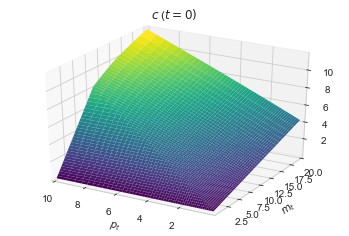

In [7]:
model_loaded.consumption_function(t=0)

**Copy** the model:

In [8]:
model_copy = model_loaded.copy() # name can be specified
print(model_copy.name)

baseline_copy


**Plot** the life-cycle profiles:

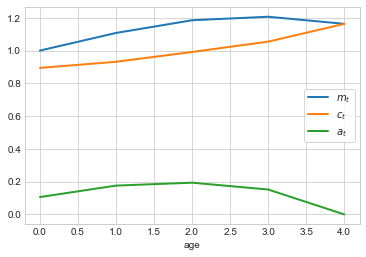

In [9]:
model_copy.lifecycle()

**Plot** an interactive version of the consumption function:

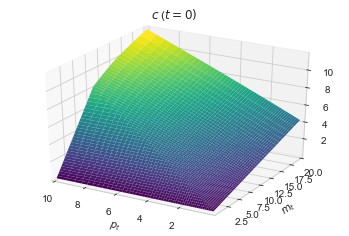

In [10]:
model_loaded.consumption_function_interact()

# Timings

**Time** the various solution methods and show the importance of the optimized computation of $q_t(p_t,a_t)$ in EGM (i.e. setting `do_simple_w = False`).

In [ ]:
for specs in [('nvfi',False),('nvfi',True),('egm',False),('egm',True),'vfi']:

    if len(specs) == 2:
        solmethod,do_simple_w = specs
    else:
        solmethod = specs
        do_simple_w = False # baseline

    # i. setup
    print(f'{solmethod}:')
    if do_simple_w:
        print('do_simple_w = True')
    model = BufferStockModelClass(name='',solmethod=solmethod,do_print=False,do_simple_w=do_simple_w)

    # ii. test run
    model.solve()
    model.par.do_print = True

    # iii. final run
    model.solve()
    model.checksum()
    print('')

nvfi:
 t = 4 solved in 0.0 secs
 t = 3 solved in 2.0 secs (w: 0.1 secs)
 t = 2 solved in 2.1 secs (w: 0.2 secs)
 t = 1 solved in 2.0 secs (w: 0.1 secs)
 t = 0 solved in 2.1 secs (w: 0.2 secs)
checksum: 3.6670746813919046

nvfi:
do_simple_w = True
 t = 4 solved in 0.0 secs
 t = 3 solved in 3.8 secs (w: 1.3 secs)
 t = 2 solved in 3.6 secs (w: 1.3 secs)
 t = 1 solved in 3.6 secs (w: 1.3 secs)
 t = 0 solved in 3.6 secs (w: 1.3 secs)
checksum: 3.667074681441266

egm:
 t = 4 solved in 0.0 secs
 t = 3 solved in 0.3 secs (w: 0.2 secs)
 t = 2 solved in 0.2 secs (w: 0.2 secs)
 t = 1 solved in 0.3 secs (w: 0.2 secs)
 t = 0 solved in 0.2 secs (w: 0.2 secs)
checksum: 3.666963241061322

egm:
do_simple_w = True
 t = 4 solved in 0.0 secs
 t = 3 solved in 1.8 secs (w: 1.7 secs)
 t = 2 solved in 1.8 secs (w: 1.8 secs)
 t = 1 solved in 1.8 secs (w: 1.7 secs)
 t = 0 solved in 1.9 secs (w: 1.9 secs)
checksum: 3.666963241061322

vfi:
 t = 4 solved in 0.0 secs


# More

See the notebook **Examples with run file and C++** for additional possibilities.